### Import modules

In [90]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

### Input variables

In [92]:
''' Silicon 111 crystal '''
# dafault crystal parameters
d_sp = 3.13557135638            # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06       # imaginary part of ""
psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
psi_hi = 2.50565837652e-06      # imaginary part of ""
psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
psi_hbi = 2.50565837652e-06     # imaginary part of ""
tc = 0.01                       # crystal thickness
ang_as = np.deg2rad(5)          # asymmetric angle
uc = 1                          # use case: 1 (Bragg reflection); 2 (Bragg transmission)

ang_dif_pl = 0                  # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

# lens parameters (PMMA)
n = 1 - 5.89e-6         # material refractive index
#d_abs = 788e-6          # material absorption depth
d_abs = 3000e-6
f_lens = 1              # lens focal distance

# aperture parameters
Apt_width = 1e-3        # aperture width (1D)
acentx = 0              # center of aperture [m]
acenty = 0

''' incident beam variables '''
ekev = 10.0                 # photon energy [kev]
pulse_duration = 10.e-15    # pulse duration (rms) [t]
z1 = 200.0                  # distance to first OE [m]
sigX = 30e-6                # w0 (rms) [m]
npoints = 2000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.5e-15                # time sampling resolution
if pulse_duration/dt <= 10:
    print('incident beam too short, changing to finer sampling resolution ...')
    dt = 0.1e-15
    if pulse_duration/dt <= 10:
        print(".... okay, the beam is really too short, simulation might break down")
hbar = 6.582119569e-16

# input dimensions
npointsx = 2                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

### Calculate sampling parameters

In [93]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 5    # spatial sampling range (5 sigma)

nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1
pulseRange = trange/pulse_duration

''' diffraction limit and focal spot Rayleigh range '''
thetamax = 2*np.arctan(divergence/2*z1*3/f_lens)
dlim = wl0/2/n/np.sin(thetamax)     # diffraction limit
zR = 1/2 * k0 * dlim**2             # focal spot Rayleigh range

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))
print('diffraction limit {}um, Rayleigh range {}mm'.format(round(dlim*1e6,2),round(zR*1e3,2)))

beam parameters:
    10.0keV, 10.0fs, 30.0um w0, 1.32urad divergence
sampling parameters:
    0.5fs dt, 6.11meV deV, 1354 nz, 67.74 pulseRange
other parameters:
    Bragg angle 11.42deg, stretched pulse length 677.4fs
diffraction limit 0.08um, Rayleigh range 0.16mm


### Generate incident wavefront

generating incident wavefront
saving incident wavefront
finished in 3.25s
R-space


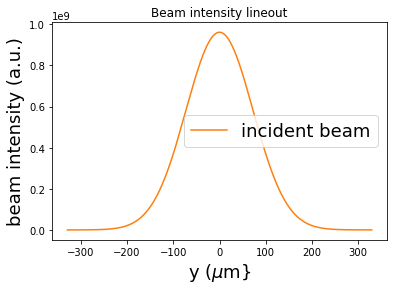

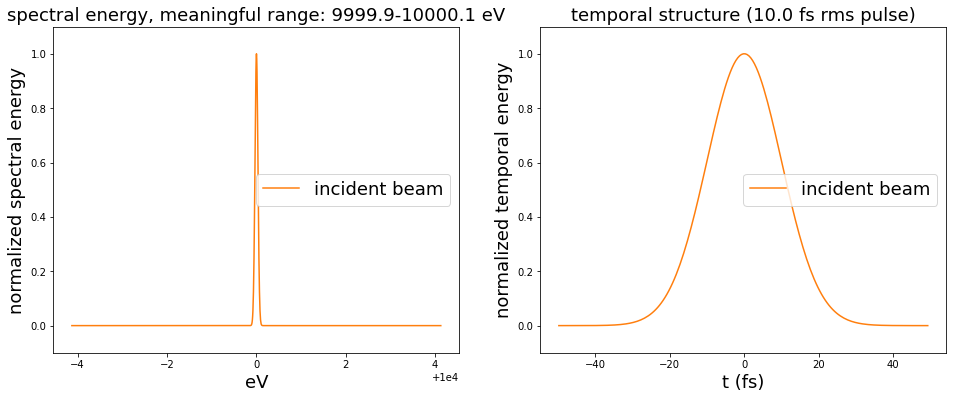

In [94]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/Hasan_Mono/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'{}kev_{}fs_beam_dt={}fs_dev={}meV/'.format(
    ekev,round(pulse_duration*1e15,1),round(dt*1e15,2),round(dev*1e3,2))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

fname_incident = dirname_input + 'incident_wavefront.h5'

''' load or generate '''
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npointsx, npointsy, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    srwl.SetRepresElecField(mwf._srwl_wf, 'f')
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)
print('finished in {}s'.format(round(time.time()-tstart,2)))

''' plot incident beam structure '''
# spatial profile
if min([npointsx, npointsy])>=4:
    plot_spatial(mwf)
    plt.title('Incident beam', fontsize=18)
else:
    plot_lineout(mwf, 'C1',label='incident beam', if_log=0)
    plt.title('Beam intensity lineout')

# spectra
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
aw, evI, intIs = plot_spectra(mwf,'C1', label='incident beam')
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin

# temporal profile
plt.subplot(1,2,2)
aw, tI, intIt = plot_temporal(mwf,'C1', label='incident beam', fov=pulse_duration*10, pulse_duration=pulse_duration)


### Fine tune sampling parameters based on incident wavefront

In [95]:
''' angular dispersion '''
e1 = evI[min(aw)]
e2 = evI[max(aw)]

# crystal orientation
nvx1, nvy1, nvz1 = Temp_Crystal.find_orient(e1,ang_dif_pl)[0][2]
nvx2, nvy2, nvz2 = Temp_Crystal.find_orient(e2,ang_dif_pl)[0][2]

# Bragg angle
thetaB1 = np.arctan(-nvz1/nvy1)+ang_as
thetaB2 = np.arctan(-nvz2/nvy2)+ang_as
print("Bragg angles: {} deg".format(np.rad2deg([thetaB1,thetaB2])))

# calculate refractive index for each energy
n1 = 2*d_sp*1e-10*np.sin(thetaB1)/E2L(e1)
n2 = 2*d_sp*1e-10*np.sin(thetaB2)/E2L(e2)
print(n1, n2)

# calculate reflection angle for each energy
thetaO1 = calcThetaO(thetaB1, ang_as, n1)
thetaO2 = calcThetaO(thetaB2, ang_as, n2)

ev_sep = (e2-e1)
dispersion = thetaO1-thetaO2
d_sep = f_lens*dispersion/5
print('energy separation: {} meV'.format(round(ev_sep*1e3,2)))
print('Dispersion: {} urad'.format(round(dispersion*1e6,4)))
print('Separation: {} um'.format(round(d_sep*1e6,2)))

if dlim <= d_sep:
    zR = 1/2 * k0 * d_sep**2
    print('diffraction limit smaller than dispersion separation')
    if zR >= 7e-3:
        zR = 7e-3
print('Rayleigh range {}mm'.format(round(zR*1e3,2)))

Bragg angles: [11.41664929 11.41579799] deg
1.0004652060837922 1.0004654450287815
energy separation: 738.19 meV
Dispersion: 13.1579 urad
Separation: 2.63 um
diffraction limit smaller than dispersion separation
Rayleigh range 7.0mm


### Crystal reflections

In [122]:
''' beamline crystals '''
ang_as0 = 0                 # asymmetry angle of the first crystal
ang_as1 = np.deg2rad(-5)     # """""""""""""""""""""" second crystal
ang_as2 = 0                 # """""""""""""""""""""" third crystal
ang_as3 = np.deg2rad(5)    # """""""""""""""""""""" 4th crystal

OE_Crystal0 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)
OE_Crystal1 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as1,_uc=uc)
OE_Crystal2 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as2,_uc=uc)
OE_Crystal3 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as3,_uc=uc)

''' crystal orientation '''
set_crystal_orient(OE_Crystal0, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(OE_Crystal1, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(OE_Crystal2, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal3, ekev*1e3, ang_dif_pl, flip=0)

''' propagation distance '''
z2 = 0.03		# distance between crystal 0 and 1
z3 = 0.02		# distance between crystal 1 and lens 0
z4 = f_lens		# distance between lens 0 and slit

dirname_prop = dirname_duration+'propagation/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#              [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppCrystal0 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC0 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal1 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC1 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppLens_Apt =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppLens_Tr =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftL =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppDriftS =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamlines '''
DriftCrystal0 = SRWLOptD(z2)    # crystal 0 to 1
DriftCrystal1 = SRWLOptD(z3)    # crystal 1 to lens 0
BL0 = SRWLOptC([OE_Crystal0, DriftCrystal0, OE_Crystal1, DriftCrystal1],
               [ppCrystal0, ppDriftC0, ppCrystal1, ppDriftC1])

''' propagation '''
startTime = time.time()

# reflected beam
print('***** propagating through crystal 0 and 1, t = {}s'.format(round(time.time()-startTime,2)))
fname_reflected = dirname_prop + 'wavefront_reflected.h5'
mwf_reflected = propagate_wavefront(fname_incident, BL0, fname_reflected)
print('\npropagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))


***** propagating through crystal 0 and 1, t = 0.0s
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 0
	aux_energy = 10000.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9802352278847529
	nvz = -0.19783553273799567
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi = 2.50565837652e-06
	psiHr = -2.71341902391e-05
	tc = 0.01
	tvx = 0
	tvy = 0.19783553273799567
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.03
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.08726646259971647
	aux_ang_dif_pl = 0
	aux_energy = 10000.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9592739365769973
	nvz = -0.28247745857691176
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi 

### Plot reflected beam

R-space
R-space


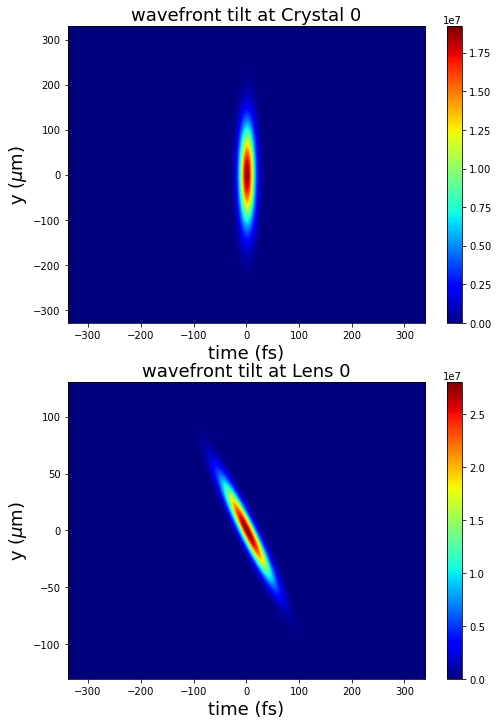

In [123]:
plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plot_tilt(mwf, 'C1', label='Crystal 0')
plt.subplot(2,1,2)
plot_tilt(mwf_reflected, 'C2', label='Lens 0')

### Lens

In [ ]:
%autoreload 2
from Optics import *

''' lens calculation '''
Lens_width = range_xy   # lens aperture size
print('calculating OPD and transmission')
Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(npoints,npoints,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=eStart,_eFin=eFin)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,npoints)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_x)
Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)
Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

print('done in {}s'.format(round(time.time()-tstart,2)))

''' aperture '''
OE_Apt = SRWLOptA('r','a',_Dx=range_xy,_Dy=Apt_width,_x=acentx, _y=acenty)

''' beamlines '''
DriftLens0 = SRWLOptD(z4_list[0])       # lens 0 to first temporal slice
BL1 = SRWLOptC([Lens_Apt, Lens_Tr, DriftLens0], [ppLens_Apt, ppLens_Tr, ppDriftL])

DriftS = SRWLOptD(z4_list[1]-z4_list[0])
BL2 = SRWLOptC([DriftS],[ppDriftS])

### Propagation through each optical element

In [58]:

# to first tslice around focal plane
print('\n\n***** propagating through lens 0, t = {}s'.format(round(time.time()-startTime,2)))
fname_focus = dirname_prop + 'wavefront_focused_slice_0.h5'
mwf_focus = propagate_wavefront(fname_reflected, BL1, fname_focus)

# between tslices
wf_holder = []
for islice in range(nslice_t):
    if islice == 0:
        mwf_focus.load_hdf5(fname_focus)
        fname_focus0 = fname_focus
        fname_focus1 = fname_focus
    else:
        print('\n\n***** propagating from slice {} to {}, t = {}s'.format(
            islice-1, islice, round(time.time()-startTime,2)))
        fname_focus0 = dirname_prop + 'wavefront_focused_slice_'+str(islice-1)+'.h5'
        fname_focus1 = dirname_prop + 'wavefront_focused_slice_'+str(islice)+'.h5'
        mwf_focus = propagate_wavefront(fname_focus0, BL2, fname_focus1)
    print(fname_focus1)
    wf_holder.append(mwf_focus)
print('\npropagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))


***** propagating through crystal 0 and 1, t = 0.0s
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 0
	aux_energy = 10000.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9802352278847529
	nvz = -0.19783553273799567
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi = 2.50565837652e-06
	psiHr = -2.71341902391e-05
	tc = 0.01
	tvx = 0
	tvy = 0.19783553273799567
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.03
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.08726646259971647
	aux_ang_dif_pl = 0
	aux_energy = 10000.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9592739365769973
	nvz = -0.28247745857691176
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi 

### Plot results

    - Crystal reflectivity + dispersion
    - Incident, reflected, and focused beam
    - tslices around focal plane

Text(0, 0.5, 'reflectivity')

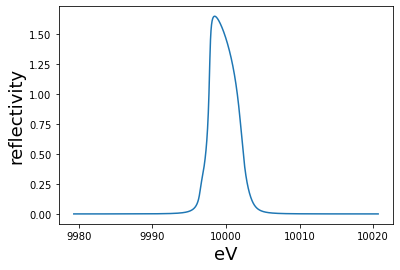

In [59]:
''' crystal reflectivity (convolved with dispersion) '''
aw, evIs, intIs = get_spectra(mwf)
aw, evRs, intRs = get_spectra(mwf_reflected)
reflectivity = intRs/intIs
#reflectivity[reflectivity>=1] = reflectivity[reflectivity>=1] /reflectivity[reflectivity>=1] 
plt.figure()
plt.plot(evIs, reflectivity)
plt.xlabel('eV',fontsize=18)
plt.ylabel('reflectivity',fontsize=18)


In [60]:
''' get slices '''
yy, lineout_holder = get_tslice_lineout(wf_holder)
aws, axis_ev, spectra_holder = get_tslice_spectra(wf_holder)
awt, axis_t, temporal_holder = get_tslice_temporal(wf_holder)

R-space


R-space
R-space
R-space


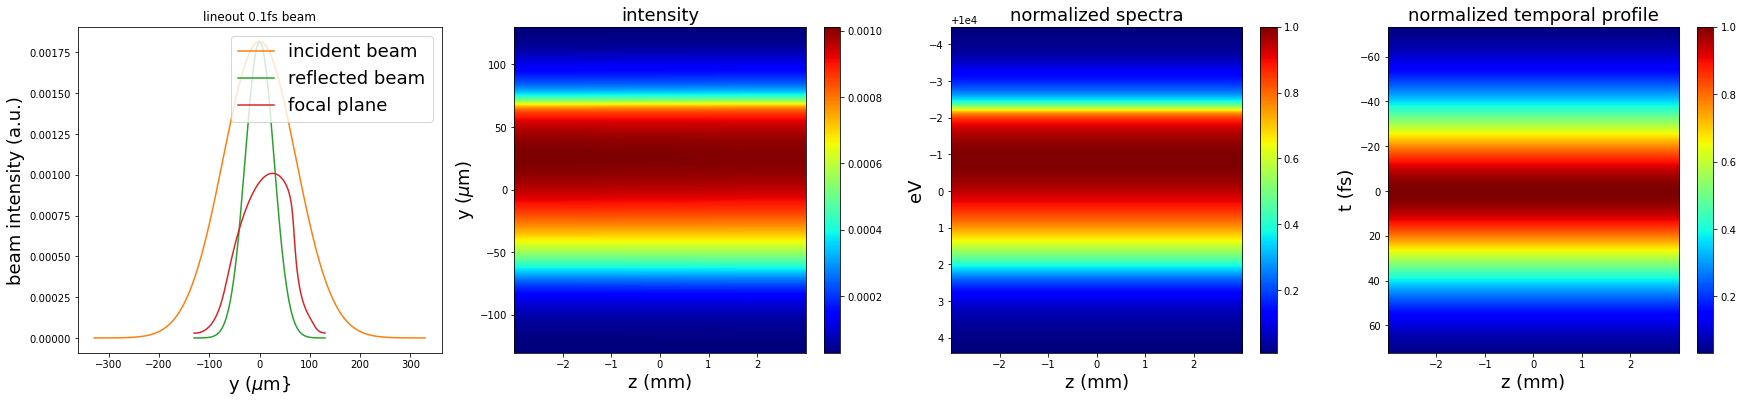

In [61]:
# import auxiliar functions
%autoreload 2
from Auxiliary import *

''' lineout '''
plt.figure(figsize=(30,6))
plt.subplot(1,4,1)
if_log = 0
if_norm = 1
plot_lineout(mwf, 'C1', label='incident beam', if_log=if_log, if_norm=if_norm)
plot_lineout(mwf_reflected, 'C2', label='reflected beam', if_log=if_log, if_norm=if_norm)
plot_lineout(wf_holder[np.argwhere(z4_list==z4)[0,0]], 'C3', label='focal plane', if_log=if_log, if_norm=if_norm)
plt.title('lineout {}fs beam'.format(round(pulse_duration*1e15,2)))

''' beam intensity around focal plane '''
plt.subplot(1,4,2)
plt.imshow(lineout_holder.T,cmap='jet',
          extent = [(z4_list[0]-z4)*1e3,(z4_list[-1]-z4)*1e3,yy[-1],yy[0]])
plt.colorbar()
plt.axis('tight')
plt.title('intensity',fontsize=18)
plt.xlabel('z (mm)',fontsize=18)
plt.ylabel(r'y ($\mu$m)',fontsize=18)

''' spectra around focal plane '''
plt.subplot(1,4,3)
plt.imshow(spectra_holder.T[min(aw):max(aw),:],cmap='jet',
          extent = [(z4_list[0]-z4)*1e3,(z4_list[-1]-z4)*1e3,axis_ev[max(aw)],axis_ev[min(aw)]])
plt.colorbar()
plt.axis('tight')
plt.title('normalized spectra',fontsize=18)
plt.xlabel('z (mm)',fontsize=18)
plt.ylabel(r'eV',fontsize=18)

''' temporal profile around focal plane '''
plt.subplot(1,4,4)
plt.imshow(temporal_holder.T[min(aw):max(aw),:],cmap='jet',
          extent = [(z4_list[0]-z4)*1e3,(z4_list[-1]-z4)*1e3,axis_t[max(aw)]*1e15,axis_t[min(aw)]*1e15])
plt.colorbar()
plt.axis('tight')
plt.title('normalized temporal profile',fontsize=18)
plt.xlabel('z (mm)',fontsize=18)
plt.ylabel('t (fs)',fontsize=18)

if z4_list.mean() == f_lens:
    plt.savefig(dirname_prop+'focal_vis_sep_bl.png')
else:
    plt.savefig(dirname_prop+'focal_vis_shifted_{}m_sep_bl.png'.format(round(z4_list.mean()-f_lens,2)))

R-space


Text(0.5, 0, 'y (um)')

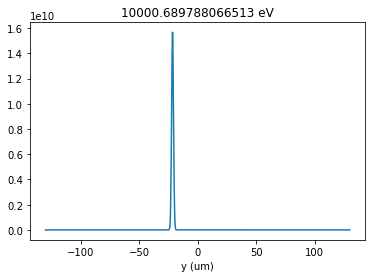

In [89]:
srwl.SetRepresElecField(mwf_focus._srwl_wf, 'f')
mwf_focus = wf_holder[1]
[xmin, xmax, ymin, ymax] = mwf_focus.get_limits()
yy = np.linspace(ymin,ymax,npointsy)
ie = 3500
plt.figure()
plt.plot(yy*1e6, mwf_focus.get_intensity()[:,1,ie])
plt.title('{} eV'.format(axis_ev[ie]))
plt.xlabel('y (um)')

In [63]:
# Calculate dispersion angle using Dumond diagram's picture
    # (dispersion as a function of b)

# check dispersion compensation

# is dev enough after resizing

# add the rest of the beamline, and put slit at focal plane, close down the slit gradually, see how bandwidth changes at one plane


# in free propagation, axis eV vs y (see where each energy slice is focused to in y)
# propagate to all OE and then don't sum axis=-1, plot the lineout as an image instead.